In [1]:
# change wokring directory to the root of the project (where jupyter was started)
import os
import psutil
%cd {psutil.Process(os.getpid()).parent().cwd()}

/home/matej/prace/ferda/ferda_github


In [2]:
!git rev-parse HEAD

9b077ff37a7f3ca35cf63511f7bde4b5e7c7f334


In [3]:
# !git checkout 9b077ff37a7f3ca35cf63511f7bde4b5e7c7f334

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from imageio import imread
import numpy as np
import os
from os.path import join
import scripts.CNN.train_interactions as train_interactions
import pandas as pd
import warnings
import yaml
pd.set_option('precision', 2)
import seaborn as sns
sns.set()

Using TensorFlow backend.


In [5]:
DATA_DIR = '/home/matej/prace/ferda/data/interactions/1801_1k_36rot_single/'
EXPERIMENT_DIR = '/home/matej/prace/ferda/experiments/180201_1525_1k_36rot_single'
SUB_EXPERIMENT = ''

In [6]:
pred = pd.read_csv(join(EXPERIMENT_DIR, str(SUB_EXPERIMENT), 'predictions.csv'))
with open(join(EXPERIMENT_DIR, str(SUB_EXPERIMENT), 'predictions.yaml'), 'r') as fr:
    metadata = yaml.load(fr)
ti = train_interactions.TrainInteractions(metadata['num_objects'])

In [7]:
y_test = pd.read_csv(join(DATA_DIR, 'test.csv'))  
for i in range(ti.num_objects):
    y_test['%d_angle_deg' % i] *= -1

In [8]:
# loss_alpha_batch = pd.read_csv(join(EXPERIMENT_DIR, 'results.csv'))    
# loss_alpha_batch[loss_alpha_batch['loss_alpha'].round(4) == round(SUB_EXPERIMENT, 4)]

In [9]:
# loss_alpha_batch.loc[loss_alpha_batch.index[-1], 'xy MAE'] = np.nan
# xy = loss_alpha_batch['xy MAE']
# loss_alpha_batch['xy MAE norm'] = (xy - xy.mean()) / xy.std()
# #loss_alpha_batch['angle MAE'].iloc[0] = np.nan
# angle = loss_alpha_batch['angle MAE']
# loss_alpha_batch['angle MAE norm'] = (angle - angle.mean()) / angle.std()
# loss_alpha_batch['sum norm'] = loss_alpha_batch['angle MAE norm'] + loss_alpha_batch['xy MAE norm']
# loss_alpha_batch['alpha sum norm'] = loss_alpha_batch['angle MAE norm'] * (1 - loss_alpha_batch['loss_alpha']) + \
#                                      loss_alpha_batch['xy MAE norm'] * loss_alpha_batch['loss_alpha']

In [10]:
# ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE', 'angle MAE'], title='mean absolute errors')
# ax.set_ylabel('deg, px')
# ax.set_xlabel('alpha')
# ax.set_ylim(0, 24)
# ax.vlines(SUB_EXPERIMENT, ax.get_ylim()[0], ax.get_ylim()[1],
#           'r')
# ax.legend(['xy', 'angle', 'best alpha'])

# Predictions

In [11]:
pred.describe()

,0_x,0_y,0_major,0_minor,0_angle_deg
count,3600.00,3600.00,3600.00,3600.00,3600.00
mean,99.70,100.39,-64.76,-3.96,8.13
std,10.89,9.95,17.37,19.01,50.12
min,73.45,77.05,-119.62,-61.80,-87.79
25%,90.20,91.91,-78.70,-15.69,-34.27
50%,99.63,100.74,-60.80,-4.26,8.24
75%,109.49,108.92,-50.76,11.51,49.22
max,129.65,125.57,-31.22,40.45,125.68


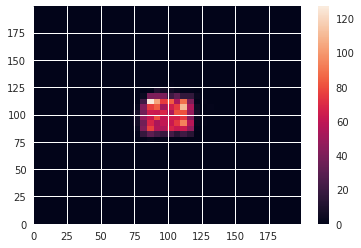

In [12]:
for i in range(ti.num_objects):
    plt.figure()
    _ = plt.hist2d(pred['%d_x' % i], pred['%d_y' % i], bins=40, range=((0, 199), (0, 199)))
    plt.colorbar()

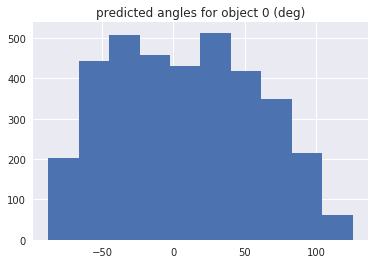

In [13]:
for i in range(ti.num_objects):
    plt.figure()
    plt.title('predicted angles for object %d (deg)' % i)
    (pred['%d_angle_deg' % i]).hist()

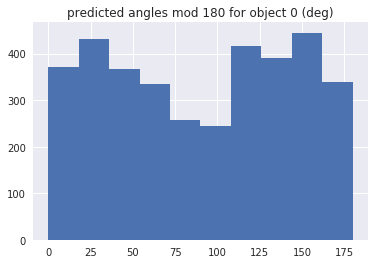

In [14]:
for i in range(ti.num_objects):
    plt.figure()
    plt.title('predicted angles mod 180 for object %d (deg)' % i)
    (pred['%d_angle_deg' % i] % 180).hist()

# Prediction Errors

In [15]:
xy, angle, indices = ti.match_pred_to_gt(pred[ti.columns()].values, y_test[ti.columns()].values, np)
if ti.num_objects == 1:
    xy_errors = xy
    angle_errors = angle
elif ti.num_objects == 2:
    xy_errors = (xy[indices[:, 0], indices[:, 1]])
    angle_errors = (angle[indices[:, 0], indices[:, 1]])
else:
    assert False, 'not implemented'

In [16]:
df = pd.DataFrame.from_items([('xy (px)', [xy_errors.mean()]), 
                              ('angle (deg)', angle_errors.mean()),])
df.style.set_caption('MAE')
df

,xy (px),angle (deg)
0,4.33,6.1


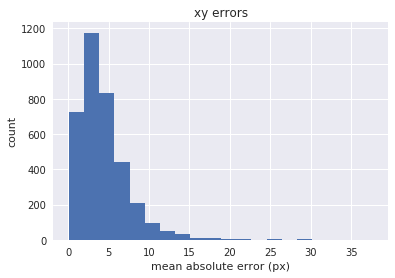

In [17]:
_  = plt.hist(xy_errors, 20)
plt.title('xy errors')
plt.xlabel('mean absolute error (px)')
plt.ylabel('count')

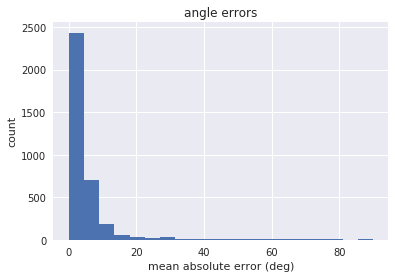

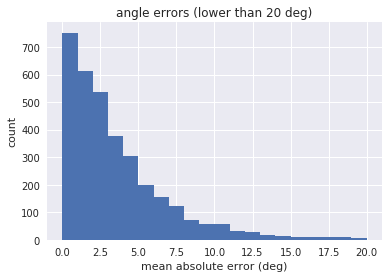

In [18]:
_ = plt.hist(angle_errors, 20) # , range=(0, 20))
plt.title('angle errors')
plt.xlabel('mean absolute error (deg)')
plt.ylabel('count')

plt.figure()
_ = plt.hist(angle_errors, 20, range=(0, 20))
plt.title('angle errors (lower than 20 deg)')
plt.xlabel('mean absolute error (deg)')
plt.ylabel('count')

# Model

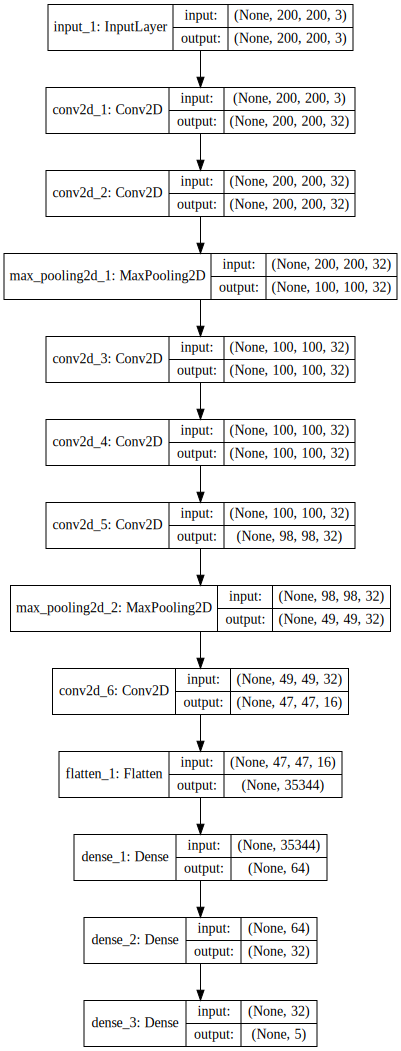

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ti.model(), show_shapes=True).create(prog='dot', format='svg'))